### Solving for a private median age of a population

To solve for a private median age of a population, we first:
1. find the median value
2. add laplace noise with global sensitivity value of max_age/2

Let's start by import the necessary libraries and loading the PUMS data.

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pa = pd.read_csv("psam_p42.csv")

Next, let's query the population we want to calculate the median age of.

In [3]:
asn_pa = pa.query('RACASN==1 and PUMA==1000')

Now, let's calculate the median age.

In [ ]:
true_median = asn_pa.AGEP.median()

Below is our implementation of the Laplace Mechanism. We want to use it to inject Laplacian-distributed noise to our median age. To do this, we need to first calculate the global sensitivity value. The global sensitivity of a median is caluculated by dividing the maximum value by two. In this case, the maximum value is the maximum age of the population.

In [ ]:
age_sensitivity = asn_pa.AGEP.max()/2

In [4]:
def laplace_mech(mu, epsilon, sensitivity=1.0):
    """Implementation of the Laplace Mechanism that adds Laplacian-distributed noise to a function.
  　
    Args:
      mu (float or numpy array): the true answer
      epsilon(int): the privacy budget
      sensitivity (float): the global sensitivity of the query
    """
    eps = epsilon/float(sensitivity)
    scale = 1/eps
    np_shape = np.shape(mu)
    shape = None if np_shape == () else np_shape
    z = np.random.laplace(0.0, scale=scale, size=shape)
    return mu + z

We can now use age_sensitivity and laplace_mech to calculate the noisy_median. We want to do this for different values of epsilon, and be able to calculate the average accuracy of the noisy_median for each of these epsilons, so that we can compare the accuracy-privacy trade off. The function below does this using L1 norm as the accuracy measure.

In [7]:
def avg_l1_median(true_median, eps, n=1000):
    total = 0
    for i in range(n):
        noisy_median = laplace_mech(true_median, eps, age_sensitivity)
        accuracy = 1 - (np.linalg.norm([noisy_median-true_median], 1)/(2*1))
        total += accuracy
    return total/n

Let's use this function to calculate the average accuracy of the noisy median over a range of epsilon values and visualize the output.

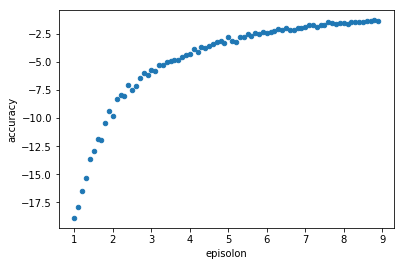

In [8]:
accuracy_df = pd.DataFrame()
eps_range = (np.arange(1.0,9.0,.1))
accuracy_df['episolon'] = eps_range
accuracy_df['accuracy'] = [avg_l1_median(true_median, x) for x in eps_range]
accuracy_df.plot.scatter('episolon', 'accuracy')
plt.show()

### Optional: Smooth Sensitivity of the Median

Noise magnitude, determined not only by the function we want to release, but also by the database itself, should not leak information about the database. To address that, we can calibrate the noise magnitude to the [smooth sensitivity](http://www.cse.psu.edu/~ads22/pubs/NRS07/NRS07-full-draft-v1.pdf) of *f* on the database *x* - a measure of the variability of *f* in the neighborhood of the instance *x*. This framework greatly expands the applicability of output perturbation, a technique for protecting individuals' privacy by adding a small amount of random noise to the released statistics. To apply the framework, one must compute or approximate the smooth sensitivity of *f* on *x*. 

<img src="ss_median.PNG">

It can be computed in time O(n log n) with the following algorithm.


In [21]:
import math

def j_list(a, c, L, U):
    """
    TODO: 
    Returns the list j*(a),...,j*(c) assuming that L<=j*(a) and j*(c)<=U
    """
    if c < a:
        return []
    else:
        b = math.floor(a+c)/2
        arg_max = 0
        for i in range(L, U+1):
            val = (x_j - x_b)*(e^(j-b+1))
            if val > argmax:
                argmax = val
        return j_list(a, b-1, L, j*(b))+j_list(b+1, c, j*(b), U)

In [18]:
# n = 1
# j_list(1, n, 1, n)